In [ ]:
import torch, pdb
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
from torchvision.utils import make_grid
from tqdm.auto import tqdm
import matplotlib.pyplot as plt


In [ ]:
try:
    from torchinfo import summary
except:
    !pip install torchinfo
    from torchinfo import summary

In [ ]:
type(16 // 4.0)

float

In [ ]:
from math import sqrt
def show(tensor, ch= 1, size= (28, 28), num_of_images= 16):
    # data = tensor.detach().cpu().view(-1, ch, *size)
    data = tensor.detach().cpu()
    grid = make_grid(data[:num_of_images], nrow= int(num_of_images // sqrt(num_of_images))).permute(1, 2, 0)
    plt.imshow(grid.clip(0, 1))
    plt.show()

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
z_dim = 100
LR = 0.0005
BATCH_SIZE = 32

loss_fn = nn.BCELoss()


In [ ]:
data = datasets.MNIST(root= 'data/', download= True, transform= transforms.ToTensor())

data_loader = DataLoader(data, BATCH_SIZE, shuffle= True)

data, len(data_loader)

100%|██████████| 9912422/9912422 [00:00<00:00, 84449409.92it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 44551560.80it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 31132469.91it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 6449061.87it/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



(Dataset MNIST
     Number of datapoints: 60000
     Root location: data/
     Split: Train
     StandardTransform
 Transform: ToTensor(),
 1875)

In [ ]:
def generator_block(input_shape, hidden_units):
    return nn.Sequential(
        nn.Linear(in_features= input_shape, out_features= hidden_units),
        nn.BatchNorm1d(hidden_units),
        nn.ReLU(inplace= True)
    )

In [ ]:
class Generator(nn.Module):
    def __init__(self, output_shape, hidden_units, z_dim= z_dim):
        super().__init__()
        self.block = nn.Sequential(
            generator_block(z_dim, hidden_units), # 100 -> 128
            generator_block(hidden_units, hidden_units * 2), # 128 -> 256
            generator_block(hidden_units * 2, hidden_units * 4), # 256 -> 512,
            generator_block(hidden_units * 4, hidden_units * 8) # 512 -> 1024
            )

        self.output_layer = nn.Linear(in_features= int(hidden_units * 8), out_features= output_shape)

    def forward(self, x):
        x = self.block(x)
        return torch.sigmoid(self.output_layer(x)) # 1024 -> 784

In [ ]:
generator = Generator(784, 128)
generator

Generator(
  (block): Sequential(
    (0): Sequential(
      (0): Linear(in_features=100, out_features=128, bias=True)
      (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Linear(in_features=128, out_features=256, bias=True)
      (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (2): Sequential(
      (0): Linear(in_features=256, out_features=512, bias=True)
      (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (3): Sequential(
      (0): Linear(in_features=512, out_features=1024, bias=True)
      (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
  )
  (output_layer): Linear(in_features=1024, out_features=784, bias=True)
)

In [ ]:
def gen_noise(number, z_dim):
    return torch.randn(number, z_dim).to(device) # number -> batch_size

In [ ]:
def discriminator_block(input_shape, output_shape):
    return nn.Sequential(
        nn.Linear(in_features= input_shape, out_features= output_shape),
        nn.LeakyReLU(negative_slope= 0.2)
    )

In [ ]:
class Discriminator(nn.Module): # Takes in the image as an input and outputs real (1) or fake (0)
    def __init__(self, input_shape: int= 784, hidden_units: int= 256, output_shape: int= 1):
        super().__init__()

        self.block = nn.Sequential(
            discriminator_block(input_shape, hidden_units * 2), # 784 -> 512
            discriminator_block(hidden_units * 2, hidden_units), # 512 -> 256
            discriminator_block(hidden_units, hidden_units // 2), # 256 -> 128
        )

        self.output_layer = nn.Linear(in_features= hidden_units // 2, out_features= output_shape) # 128 -> 1

    def forward(self, x):
        x = self.block(x)
        return torch.sigmoid(self.output_layer(x))

In [ ]:
generator = Generator(784, 128).to(device)
discriminator = Discriminator().to(device)


In [ ]:
summary(discriminator, (32, 784), col_names= ["input_size", "output_size", "num_params", "trainable"], col_width= 20)

Layer (type:depth-idx)                   Input Shape          Output Shape         Param #              Trainable
Discriminator                            [32, 784]            [32, 1]              --                   True
├─Sequential: 1-1                        [32, 784]            [32, 128]            --                   True
│    └─Sequential: 2-1                   [32, 784]            [32, 512]            --                   True
│    │    └─Linear: 3-1                  [32, 784]            [32, 512]            401,920              True
│    │    └─LeakyReLU: 3-2               [32, 512]            [32, 512]            --                   --
│    └─Sequential: 2-2                   [32, 512]            [32, 256]            --                   True
│    │    └─Linear: 3-3                  [32, 512]            [32, 256]            131,328              True
│    │    └─LeakyReLU: 3-4               [32, 256]            [32, 256]            --                   --
│    └─Sequential:

In [ ]:
generator_optimizer = torch.optim.Adam(generator.parameters(), lr= LR)
discriminator_optimizer = torch.optim.Adam(discriminator.parameters(), lr= LR)

NameError: ignored

In [ ]:
X, y = next(iter(data_loader))
X.shape, y.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

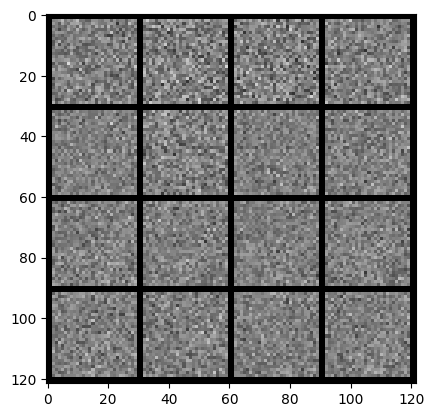

In [ ]:
noise = gen_noise(BATCH_SIZE, z_dim)
fake_image = generator(noise)
show(fake_image)

In [ ]:
# generator_loss
def cal_generator_loss(loss_fn, generator, discriminator, number, z_dim= z_dim):
    noise = gen_noise(BATCH_SIZE, z_dim)
    fake_images = generator(noise)
    pred = discriminator(fake_images)
    gen_loss = loss_fn(pred, torch.ones_like(pred))
    return gen_loss

In [ ]:
# Discriminator Loss
def cal_discriminator_loss(loss_fn, generator, discriminator, number, real_images, z_dim= z_dim):
    noise = gen_noise(BATCH_SIZE, z_dim)
    fake_images = generator(noise)
    pred = discriminator(fake_images.detach()) # So that this step doesn't change the genenrator's weights
    dis_loss_fake = loss_fn(pred, torch.zeros_like(pred))

    pred_real = discriminator(real_images.to(device))
    dis_loss_real = loss_fn(pred_real, torch.ones_like(pred_real))

    dis_loss = (dis_loss_fake + dis_loss_real) / 2
    return dis_loss

  0%|          | 0/10 [00:00<?, ?it/s]


Epoch: 0 and batch: 600
Mean generator loss: 0.004754348993301392
Mean discriminator loss: 0.0001524505764245987


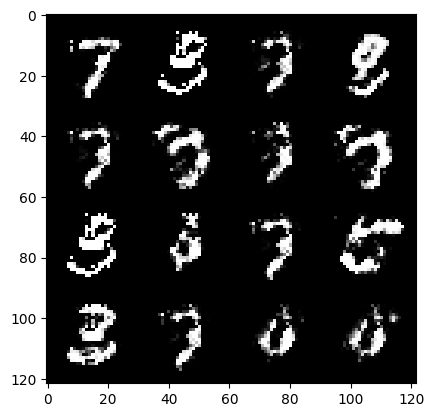


Epoch: 0 and batch: 1200
Mean generator loss: 0.0018097953001658122
Mean discriminator loss: 0.00014714106917381286


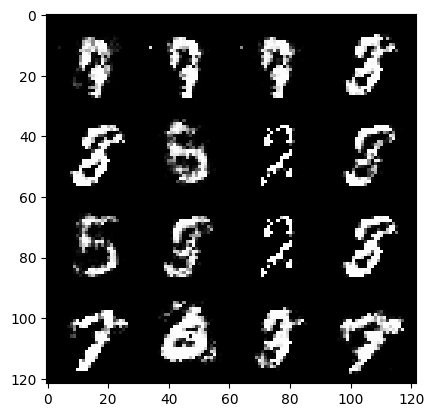


Epoch: 0 and batch: 1800
Mean generator loss: 0.001546416547563341
Mean discriminator loss: 0.00014342980252371893


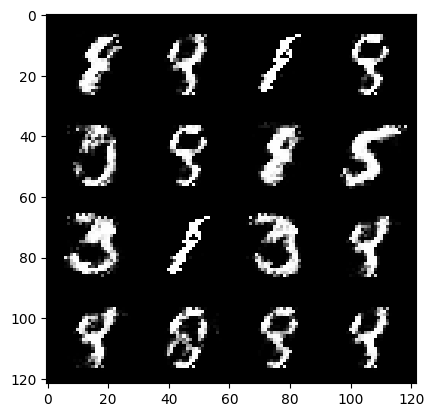


Epoch: 1 and batch: 600
Mean generator loss: 0.0045118796825408935
Mean discriminator loss: 0.00032401772836844126


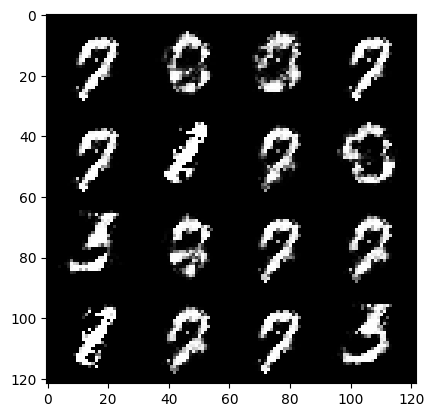


Epoch: 1 and batch: 1200
Mean generator loss: 0.002152918974558512
Mean discriminator loss: 0.00012926506499449412


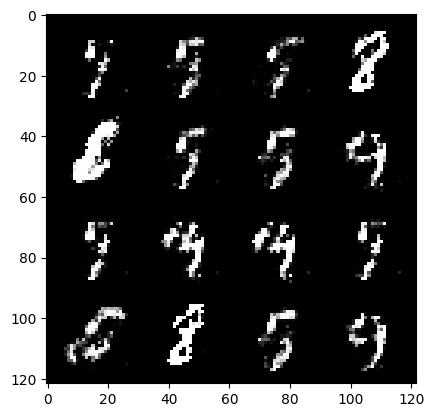


Epoch: 1 and batch: 1800
Mean generator loss: 0.0014805510309007432
Mean discriminator loss: 0.0001710718870162964


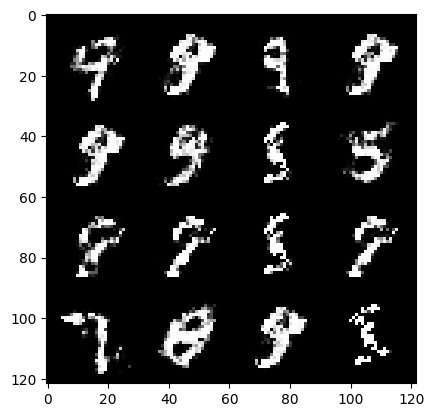


Epoch: 2 and batch: 600
Mean generator loss: 0.004981432358423869
Mean discriminator loss: 0.00019327896336714427


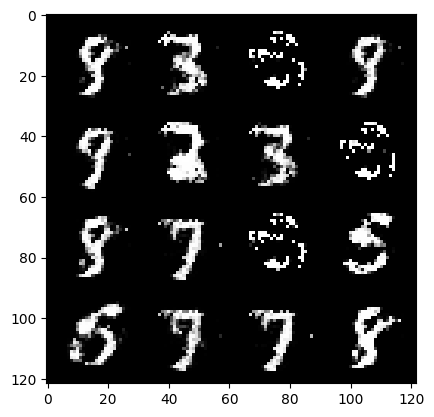


Epoch: 2 and batch: 1200
Mean generator loss: 0.002715480327606201
Mean discriminator loss: 0.00013990025967359544


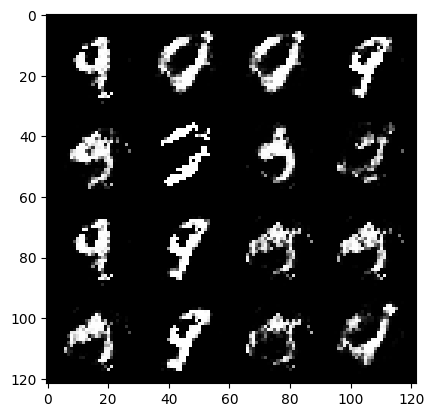


Epoch: 2 and batch: 1800
Mean generator loss: 0.0015037096871270074
Mean discriminator loss: 0.00016667240195804173


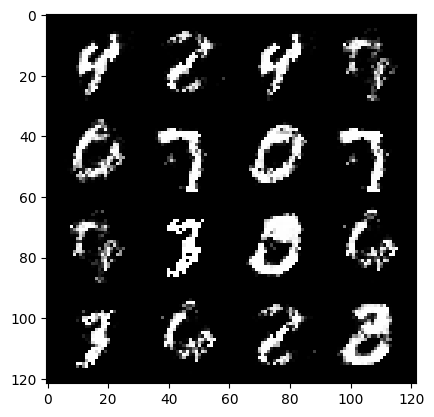


Epoch: 3 and batch: 600
Mean generator loss: 0.004605201880137125
Mean discriminator loss: 0.00015471185247103373


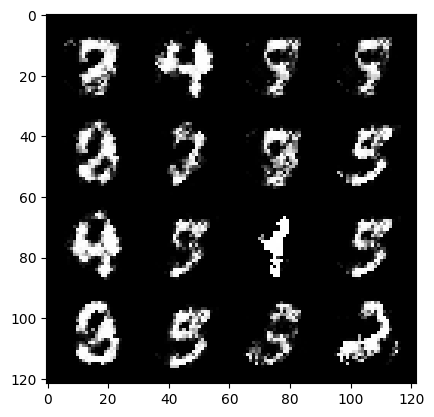


Epoch: 3 and batch: 1200
Mean generator loss: 0.0021942726771036784
Mean discriminator loss: 0.00010172191386421522


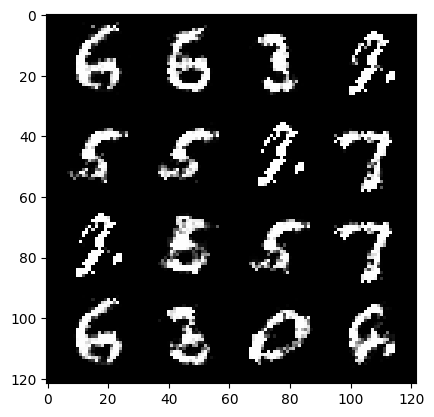


Epoch: 3 and batch: 1800
Mean generator loss: 0.0016945306460062664
Mean discriminator loss: 6.353133254581028e-05


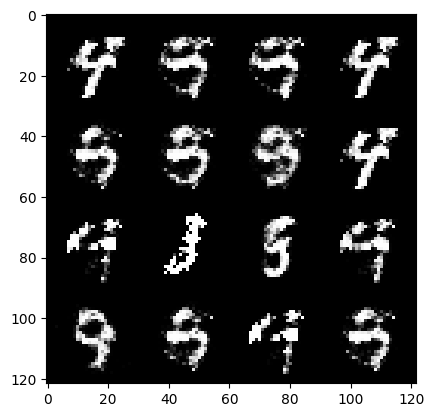


Epoch: 4 and batch: 600
Mean generator loss: 0.004732813040415446
Mean discriminator loss: 0.0005573991934458415


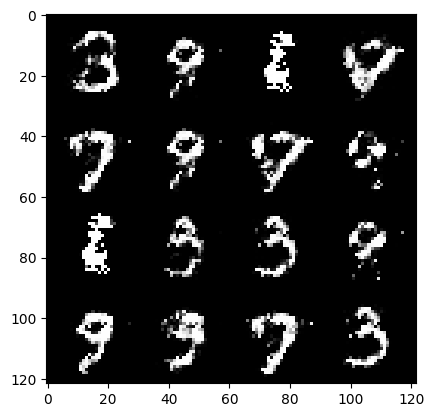


Epoch: 4 and batch: 1200
Mean generator loss: 0.002278054157892863
Mean discriminator loss: 0.0002384002258380254


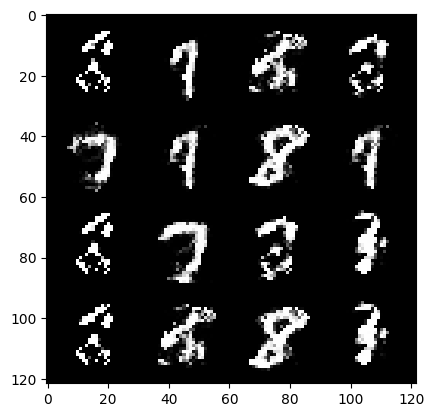


Epoch: 4 and batch: 1800
Mean generator loss: 0.0016899771160549587
Mean discriminator loss: 0.00010990616348054674


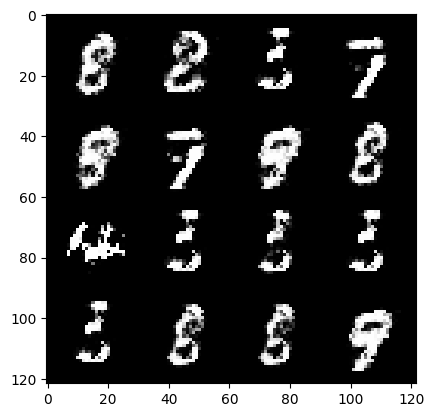


Epoch: 5 and batch: 600
Mean generator loss: 0.004330519437789917
Mean discriminator loss: 0.00046864867210388183


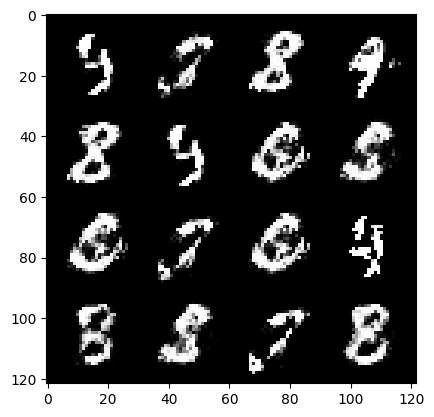


Epoch: 5 and batch: 1200
Mean generator loss: 0.0021966580549875893
Mean discriminator loss: 0.00022228732705116273


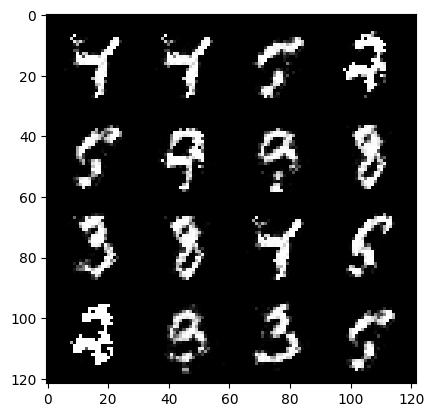


Epoch: 5 and batch: 1800
Mean generator loss: 0.0013540509012010362
Mean discriminator loss: 7.52680500348409e-05


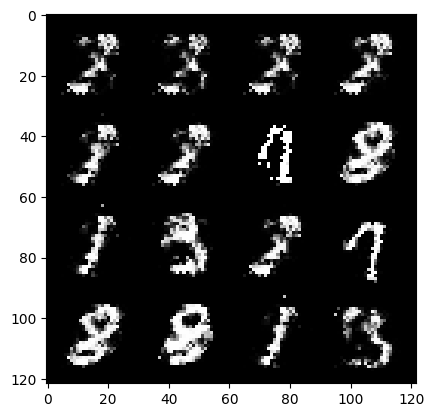


Epoch: 6 and batch: 600
Mean generator loss: 0.004711701075236003
Mean discriminator loss: 0.0002473319321870804


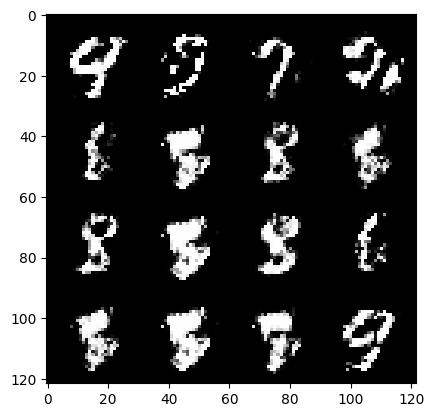


Epoch: 6 and batch: 1200
Mean generator loss: 0.0022038761774698895
Mean discriminator loss: 0.000286772350470225


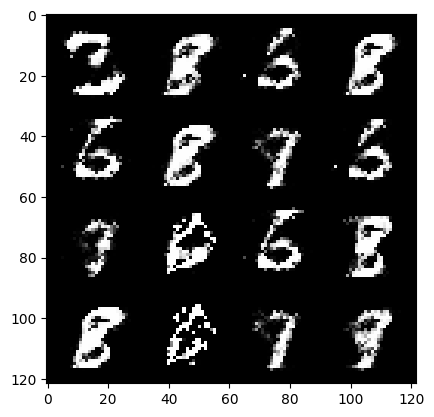


Epoch: 6 and batch: 1800
Mean generator loss: 0.001785100433561537
Mean discriminator loss: 4.6612098813056946e-05


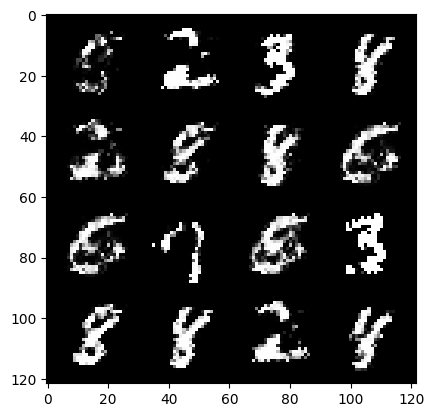


Epoch: 7 and batch: 600
Mean generator loss: 0.0047057791550954185
Mean discriminator loss: 0.000381975124279658


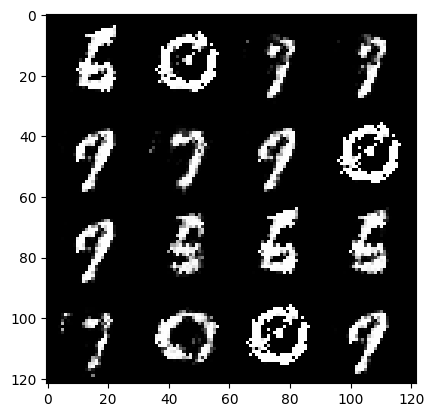


Epoch: 7 and batch: 1200
Mean generator loss: 0.002403641939163208
Mean discriminator loss: 9.005832175413768e-05


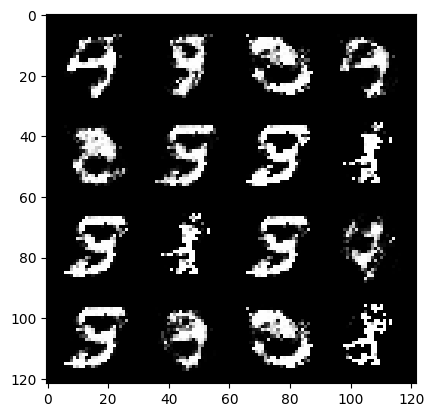


Epoch: 7 and batch: 1800
Mean generator loss: 0.0014121956295437283
Mean discriminator loss: 0.00011980899506145053


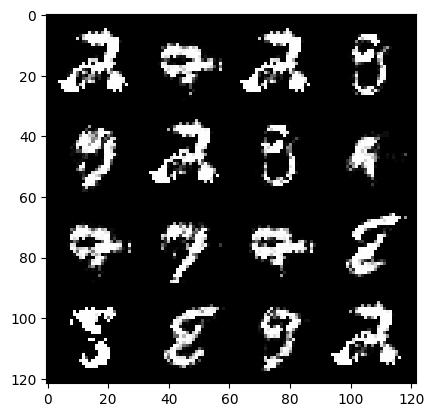


Epoch: 8 and batch: 600
Mean generator loss: 0.004790392716725668
Mean discriminator loss: 0.0002406078577041626


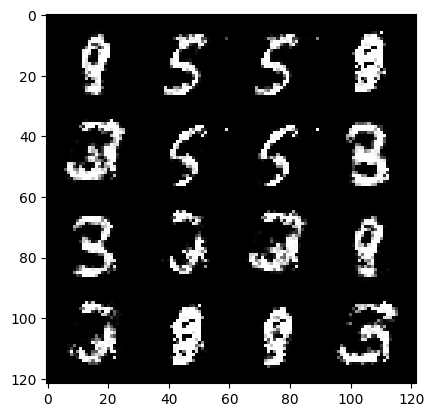


Epoch: 8 and batch: 1200
Mean generator loss: 0.0018428289890289307
Mean discriminator loss: 0.00011959005147218704


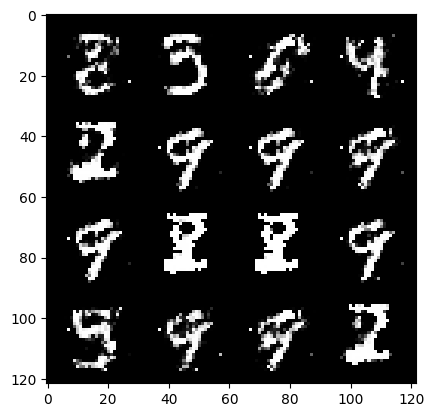


Epoch: 8 and batch: 1800
Mean generator loss: 0.0017742305331759983
Mean discriminator loss: 6.855974594751993e-05


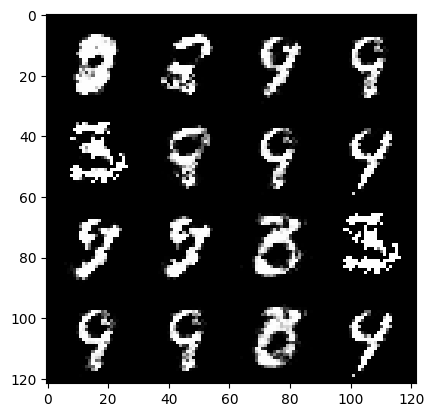


Epoch: 9 and batch: 600
Mean generator loss: 0.004747877915700277
Mean discriminator loss: 0.0003166836748520533


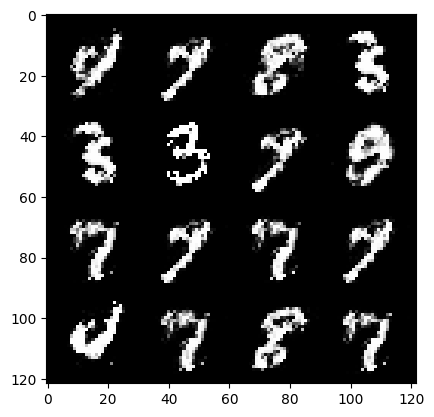


Epoch: 9 and batch: 1200
Mean generator loss: 0.0026178765296936035
Mean discriminator loss: 7.700589795907339e-05


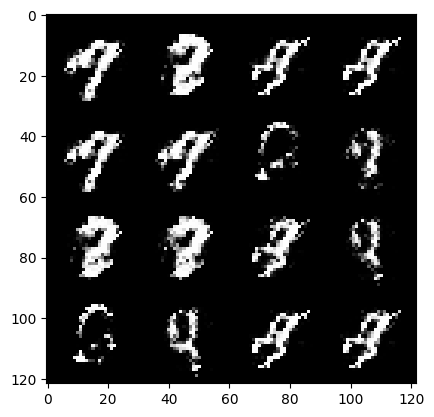


Epoch: 9 and batch: 1800
Mean generator loss: 0.0014905479219224718
Mean discriminator loss: 8.687790897157457e-05


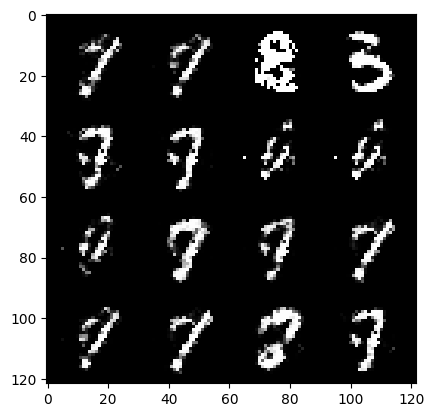

In [ ]:
# Training Loop
mean_generator_loss = 0
mean_discriminator_loss = 0
epochs = 10
for epoch in tqdm(range(epochs)):
    for batch, (real_images, labels) in enumerate(data_loader):
        ## Discriminator training
        discriminator_optimizer.zero_grad()
        real_images = real_images.view(BATCH_SIZE, -1) # (32, 1, 28, 28) -> (32, 784)
        real_images.to(device)
        discriminator_loss = cal_discriminator_loss(loss_fn, generator, discriminator, BATCH_SIZE, real_images)

        discriminator_loss.backward()
        discriminator_optimizer.step()

        ## Generator training
        generator_optimizer.zero_grad()
        gen_loss = cal_generator_loss(loss_fn, generator, discriminator, BATCH_SIZE)
        gen_loss.backward()
        generator_optimizer.step()

        ## Visualisation
        if (batch + 1) % 600 == 0:
            print(f"\nEpoch: {epoch} and batch: {batch + 1}")
            mean_discriminator_loss += discriminator_loss.item() / (batch + 1)
            mean_generator_loss += gen_loss.item() / (batch + 1)
            noise = gen_noise(BATCH_SIZE, z_dim)
            fake_images = generator(noise)
            print(f"Mean generator loss: {mean_generator_loss}")
            print(f"Mean discriminator loss: {mean_discriminator_loss}")
            mean_generator_loss, mean_discriminator_loss = 0, 0
            show(fake_images)
            # show(real_images)

In [ ]:
def gen_noise(number, z_dim):
    return torch.randn(number, z_dim, 1, 1).to(device) # number -> batch_size

In [ ]:
class Generator(nn.Module):
    def __init__(self, latent_dim, hidden_units, output_shape= 3): #latent_dim -> the random noise vector, output_size = 28*28 = 784 for MNIST
        super().__init__()
        self.input_layer = nn.Sequential(
            nn.ConvTranspose2d(in_channels= latent_dim, out_channels= hidden_units * 8, stride= 2, kernel_size= 7, padding= 0, bias= False),
            nn.BatchNorm2d(num_features= hidden_units * 8),
            nn.ReLU(inplace= True))

        self.conv_block = nn.Sequential(
            nn.ConvTranspose2d(in_channels= hidden_units * 8, out_channels= hidden_units * 4, stride= 2, kernel_size= 4, padding= 1, bias= False),
            nn.BatchNorm2d(num_features= hidden_units * 4),
            nn.ReLU(inplace= True),
        )

        self.conv_block2 = nn.Sequential(
            nn.ConvTranspose2d(in_channels= hidden_units * 4, out_channels= hidden_units * 2, stride= 2, kernel_size= 4, padding= 1, bias= False),
            nn.BatchNorm2d(num_features= hidden_units * 2),
            nn.ReLU(inplace= True)
        )

        self.conv_block3 = nn.Sequential(
            nn.ConvTranspose2d(in_channels= hidden_units * 2, out_channels= hidden_units, stride= 2, kernel_size= 4, padding= 1, bias= False),
            nn.BatchNorm2d(num_features= hidden_units),
            nn.ReLU(inplace= True),
            nn.AveragePool2d(kernel_size= 2)
        )

        self.conv_block3 = nn.Sequential(
            nn.ConvTranspose2d(in_channels= hidden_units * 2, out_channels= hidden_units, stride= 2, kernel_size= 4, padding= 1, bias= False),
            nn.BatchNorm2d(num_features= hidden_units),
            nn.ReLU(inplace= True),
            nn.AveragePool2d(kernel_size= 2)
        )

        self.classifier_layer = nn.Sequential(
            nn.ConvTranspose2d(in_channels= hidden_units, out_channels= output_shape, stride= 2, kernel_size= 4, padding= 1, bias= False),
            nn.AveragePool2d(kernel_size= 2),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.conv_block(self.input_layer(x))
        x = self.conv_block2(x)
        x = self.conv_block3(x)
        return self.classifier_layer(x)

In [ ]:
generator = Generator(100, 64, 1).to(device)
summary(generator, (32, 100, 1, 1), col_names= ["input_size", "output_size", "num_params", "trainable"], col_width= 20)

Layer (type:depth-idx)                   Input Shape          Output Shape         Param #              Trainable
Generator                                [32, 100, 1, 1]      [32, 1, 28, 28]      --                   True
├─Sequential: 1-1                        [32, 100, 1, 1]      [32, 512, 7, 7]      --                   True
│    └─ConvTranspose2d: 2-1              [32, 100, 1, 1]      [32, 512, 7, 7]      2,508,800            True
│    └─BatchNorm2d: 2-2                  [32, 512, 7, 7]      [32, 512, 7, 7]      1,024                True
│    └─ReLU: 2-3                         [32, 512, 7, 7]      [32, 512, 7, 7]      --                   --
├─Sequential: 1-2                        [32, 512, 7, 7]      [32, 256, 14, 14]    --                   True
│    └─ConvTranspose2d: 2-4              [32, 512, 7, 7]      [32, 256, 14, 14]    2,097,152            True
│    └─BatchNorm2d: 2-5                  [32, 256, 14, 14]    [32, 256, 14, 14]    512                  True
│    └─ReLU: 2-6

In [ ]:
generator

Generator(
  (input_layer): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(7, 7), stride=(2, 2), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv_block): Sequential(
    (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv_block2): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv_block3): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool